<a href="https://colab.research.google.com/github/MillionHappa/Spark/blob/main/Spark%2B_%E6%8E%A1%E7%94%A8%E8%AA%B2%E9%A1%8C_1_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#データのimport



In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    roc_curve,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

import seaborn as sns

import torch.nn.functional as F

from sklearn.preprocessing import label_binarize

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


#モデルの選定

In [ ]:
#conv1をcifar10のサイズに合わせて変更
def get_cifar10_resnet50():
    model = resnet50(weights=ResNet50_Weights.DEFAULT) #pretrained=Trueと同じ
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, 10) #10クラス分類のため
    return model

model = get_cifar10_resnet50().to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 217MB/s]


#Data Augmentation

#Combination


#Basic

##Basic Standard

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float()).item()

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)

        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float()).item()

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

epoch: 0, loss: 0.626046642527623, acc: 0.7806301983365324, val loss: 0.2782448381066513, val acc: 0.9051517571884984
epoch: 1, loss: 0.2013997597219476, acc: 0.931182021753039, val loss: 0.21103612520395756, val acc: 0.9277156549520766
epoch: 2, loss: 0.09204560897675934, acc: 0.9687300063979527, val loss: 0.2034469213427458, val acc: 0.9347044728434505
epoch: 3, loss: 0.05465976055231099, acc: 0.9809061100447857, val loss: 0.2223278537917787, val acc: 0.9302116613418531
epoch: 4, loss: 0.03947014300217012, acc: 0.986724248240563, val loss: 0.20936381374113858, val acc: 0.9368011182108626
epoch: 5, loss: 0.027841768086150822, acc: 0.9907629558541267, val loss: 0.224669073322288, val acc: 0.9370007987220448
epoch: 6, loss: 0.019480186604563215, acc: 0.9936020473448497, val loss: 0.20607399045905922, val acc: 0.943091054313099
epoch: 7, loss: 0.020533645941281844, acc: 0.9929622520793346, val loss: 0.22942280738180082, val acc: 0.9385982428115016
epoch: 8, loss: 0.021576033200339573, ac

Accuracy: 0.9407

Classification Report:
               precision    recall  f1-score   support

       plane     0.9652    0.9150    0.9394      1000
         car     0.9594    0.9680    0.9637      1000
        bird     0.9051    0.9350    0.9198      1000
         cat     0.8663    0.9070    0.8862      1000
        deer     0.9291    0.9570    0.9429      1000
         dog     0.9246    0.8710    0.8970      1000
        frog     0.9611    0.9630    0.9620      1000
       horse     0.9745    0.9550    0.9646      1000
        ship     0.9679    0.9650    0.9664      1000
       truck     0.9595    0.9710    0.9652      1000

    accuracy                         0.9407     10000
   macro avg     0.9413    0.9407    0.9407     10000
weighted avg     0.9413    0.9407    0.9407     10000



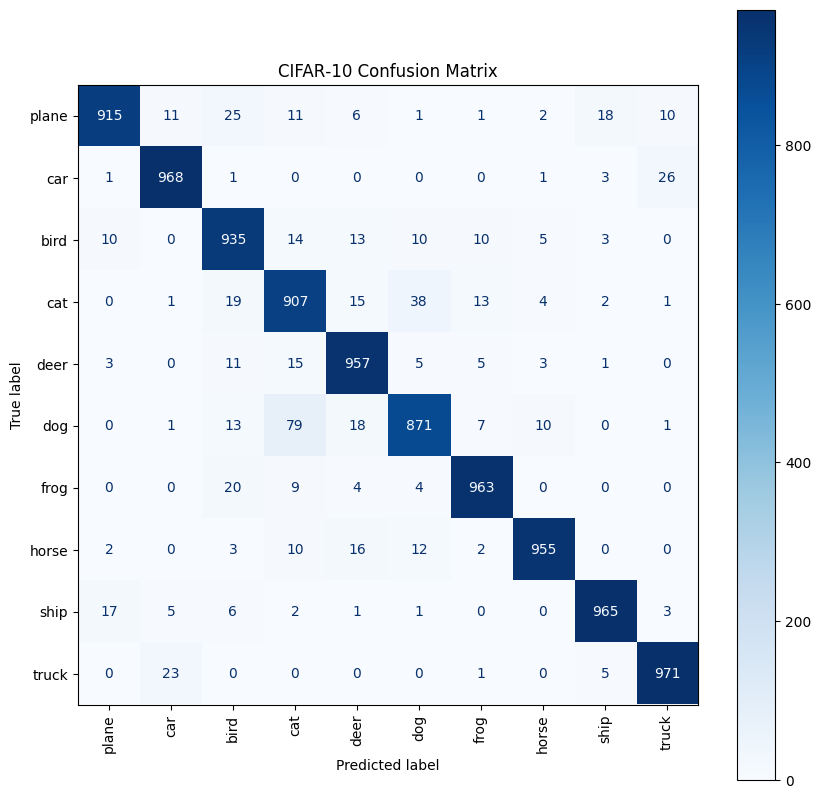

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.show()


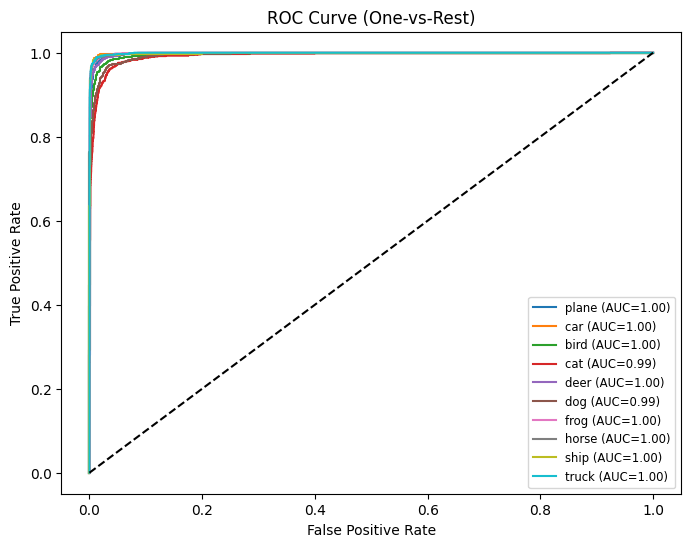

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.show()

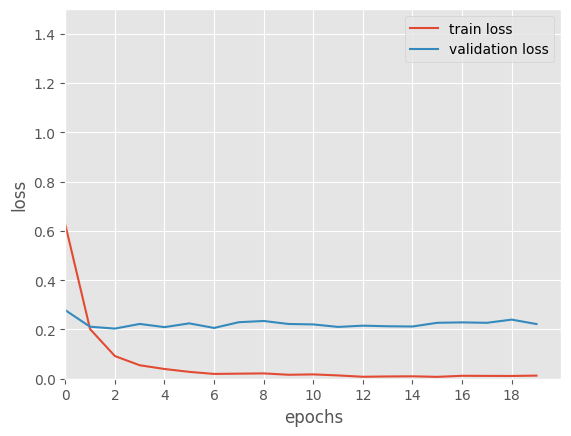

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0,20)
plt.ylim(0,1.5)
plt.xticks(range(0, 19, 2))
plt.legend()

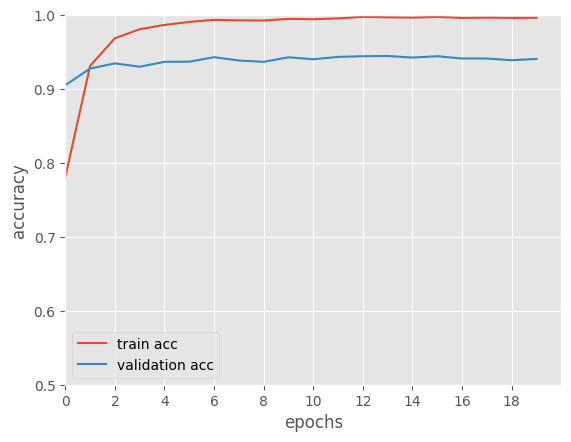

In [ ]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0,20)
plt.ylim(0.5,1)
plt.xticks(range(0, 19, 2))
plt.legend()

## Basic Preprocessing

In [ ]:
class gcn():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ


# 標準化後の画像を[0, 1]に正規化する
def deprocess(x):
    _min = np.min(x)
    _max = np.max(x)
    _x = (x - _min)/(_max - _min)
    return _x

In [ ]:
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        x = images[0][0].reshape(1, -1)  # 画像（1枚）を1次元化
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)  # 平均値を格納するテンソル．xと同じ形状
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        # E: 固有値 V: 固有ベクトルを並べたもの
        E, V = torch.linalg.eigh(con_matrix)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())  # A(\Lambda + \epsilon I)^{1/2}A^T
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean  # x - \bar{x}
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x

zca = ZCAWhitening()
raw_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
zca.fit(raw_dataset)

GCN = gcn()

train_transform = transforms.Compose([
    transforms.ToTensor(),
    GCN,
    zca,
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    GCN,
    zca,
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float()).item()

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)

        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float()).item()

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

epoch: 0, loss: 0.09729430119077105, acc: 0.967530369758606, val loss: 0.2508856997209283, val acc: 0.925319492816925
epoch: 1, loss: 0.040565128803015355, acc: 0.9863843321800232, val loss: 0.24293454754100843, val acc: 0.9309105277061462
epoch: 2, loss: 0.026529542598224265, acc: 0.9911628365516663, val loss: 0.24972515610290674, val acc: 0.9292132258415222
epoch: 3, loss: 0.01689708925173273, acc: 0.9948016405105591, val loss: 0.27226867539117844, val acc: 0.9274161458015442
epoch: 4, loss: 0.013243609404706454, acc: 0.9958213567733765, val loss: 0.25267326157315434, val acc: 0.9353035092353821
epoch: 5, loss: 0.011707462598813247, acc: 0.996141254901886, val loss: 0.25229323779815993, val acc: 0.9355031847953796
epoch: 6, loss: 0.015322819768669442, acc: 0.9949415922164917, val loss: 0.248489353870032, val acc: 0.9376996755599976
epoch: 7, loss: 0.009125699645173893, acc: 0.9970609545707703, val loss: 0.2290566195696652, val acc: 0.9418929815292358
epoch: 8, loss: 0.011023387068732

Accuracy: 0.9372

Classification Report:
               precision    recall  f1-score   support

       plane     0.9538    0.9300    0.9418      1000
         car     0.9596    0.9740    0.9667      1000
        bird     0.9467    0.9230    0.9347      1000
         cat     0.8549    0.8720    0.8634      1000
        deer     0.9178    0.9600    0.9384      1000
         dog     0.9104    0.8840    0.8970      1000
        frog     0.9585    0.9480    0.9532      1000
       horse     0.9665    0.9520    0.9592      1000
        ship     0.9457    0.9760    0.9606      1000
       truck     0.9607    0.9530    0.9568      1000

    accuracy                         0.9372     10000
   macro avg     0.9375    0.9372    0.9372     10000
weighted avg     0.9375    0.9372    0.9372     10000



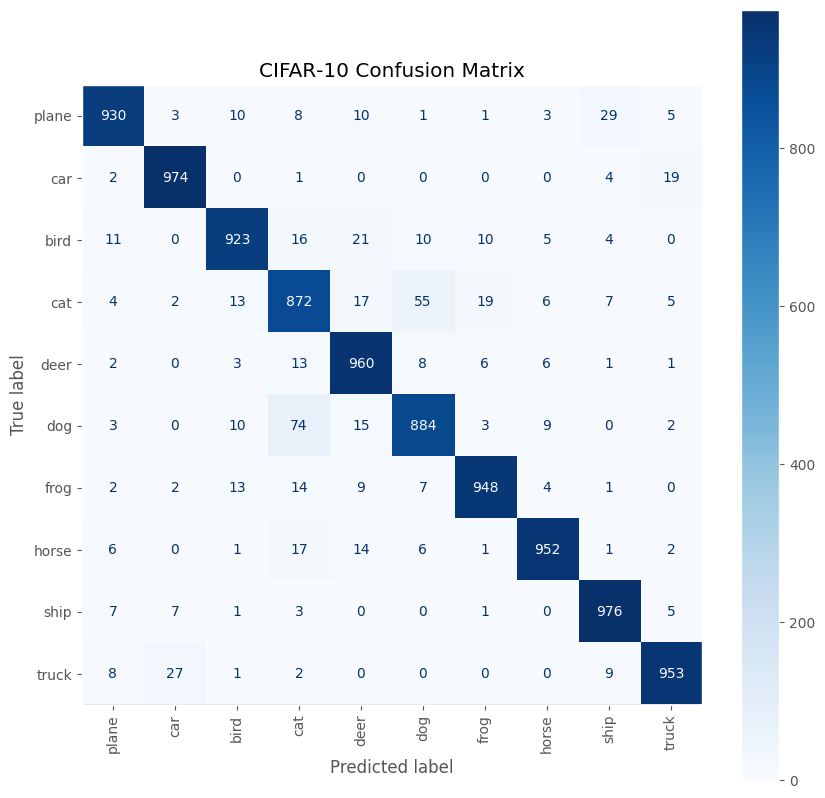

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.grid(False)
plt.show()


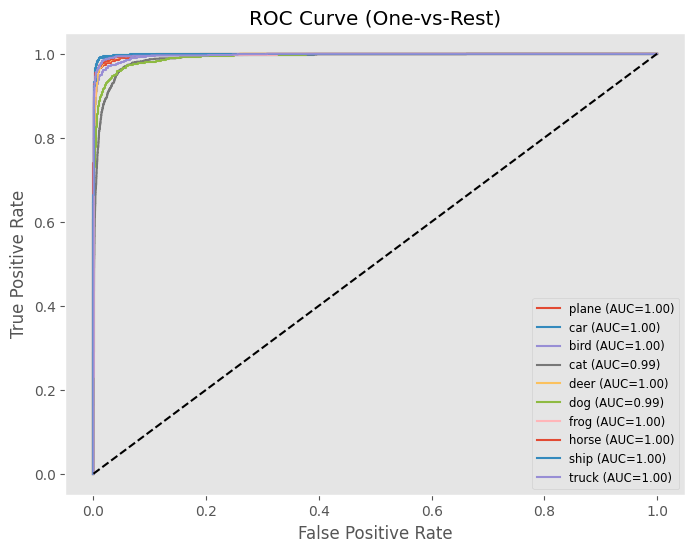

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(False)
plt.show()

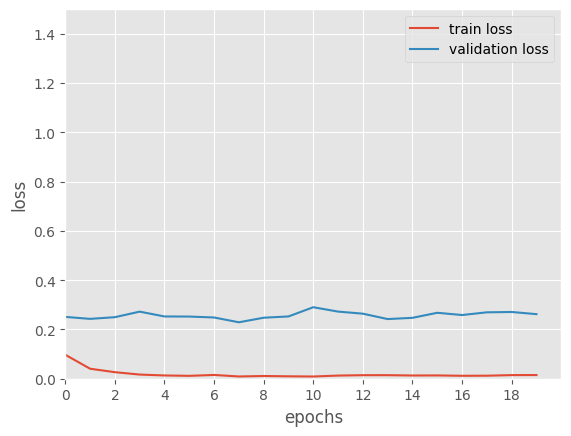

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0,20)
plt.ylim(0,1.5)
plt.xticks(range(0, 19, 2))
plt.legend()

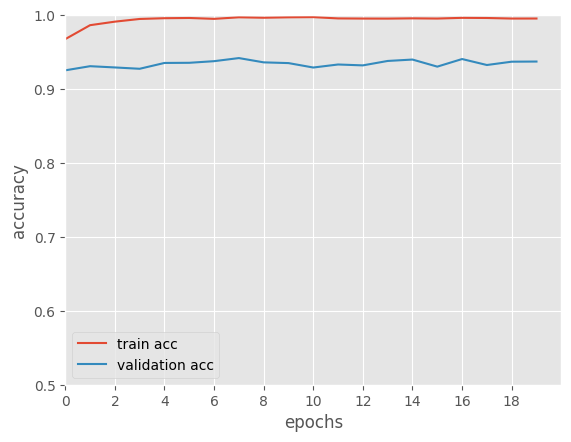

In [ ]:
plt.plot([accs_.cpu() for accs_ in accs], label="train acc")
plt.plot([accs_.cpu() for accs_ in val_accs], label="validation acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0,20)
plt.ylim(0.5,1)
plt.xticks(range(0, 19, 2))
plt.legend()

## Basic Preprocessing without Normalization

In [ ]:
class gcn():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ


# 標準化後の画像を[0, 1]に正規化する
def deprocess(x):
    _min = np.min(x)
    _max = np.max(x)
    _x = (x - _min)/(_max - _min)
    return _x

In [ ]:
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        x = images[0][0].reshape(1, -1)  # 画像（1枚）を1次元化
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)  # 平均値を格納するテンソル．xと同じ形状
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        # E: 固有値 V: 固有ベクトルを並べたもの
        E, V = torch.linalg.eigh(con_matrix)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())  # A(\Lambda + \epsilon I)^{1/2}A^T
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean  # x - \bar{x}
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x

zca = ZCAWhitening()
raw_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
zca.fit(raw_dataset)

GCN = gcn()

train_transform = transforms.Compose([
    transforms.ToTensor(),
    GCN,
    zca
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    GCN,
    zca
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float()).item()

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)

        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float()).item()

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

epoch: 0, loss: 0.5443496177460395, acc: 0.8138595649392194, val loss: 0.28495791159308376, val acc: 0.9065495207667732
epoch: 1, loss: 0.1785080301928705, acc: 0.9390395073576455, val loss: 0.25731190143170923, val acc: 0.9220247603833865
epoch: 2, loss: 0.08494418034236462, acc: 0.9705294305822136, val loss: 0.31733150148880296, val acc: 0.9207268370607029
epoch: 3, loss: 0.04961241222690864, acc: 0.9830854126679462, val loss: 0.24515413536657446, val acc: 0.9352036741214057
epoch: 4, loss: 0.038997874818344914, acc: 0.9862843889955214, val loss: 0.22050577998548127, val acc: 0.9354033546325878
epoch: 5, loss: 0.027904254980036354, acc: 0.9911628278950736, val loss: 0.22099468211558596, val acc: 0.9389976038338658
epoch: 6, loss: 0.019971181582928734, acc: 0.9934221049264236, val loss: 0.23247277218113527, val acc: 0.9377995207667732
epoch: 7, loss: 0.01719693706475407, acc: 0.994321817018554, val loss: 0.21845368236919252, val acc: 0.9425918530351438
epoch: 8, loss: 0.01451394354099

Accuracy: 0.9333

Classification Report:
               precision    recall  f1-score   support

       plane     0.9112    0.9640    0.9368      1000
         car     0.9610    0.9610    0.9610      1000
        bird     0.9422    0.9130    0.9274      1000
         cat     0.8422    0.8910    0.8659      1000
        deer     0.9241    0.9490    0.9364      1000
         dog     0.9162    0.8420    0.8775      1000
        frog     0.9376    0.9760    0.9564      1000
       horse     0.9821    0.9330    0.9569      1000
        ship     0.9715    0.9540    0.9627      1000
       truck     0.9538    0.9500    0.9519      1000

    accuracy                         0.9333     10000
   macro avg     0.9342    0.9333    0.9333     10000
weighted avg     0.9342    0.9333    0.9333     10000



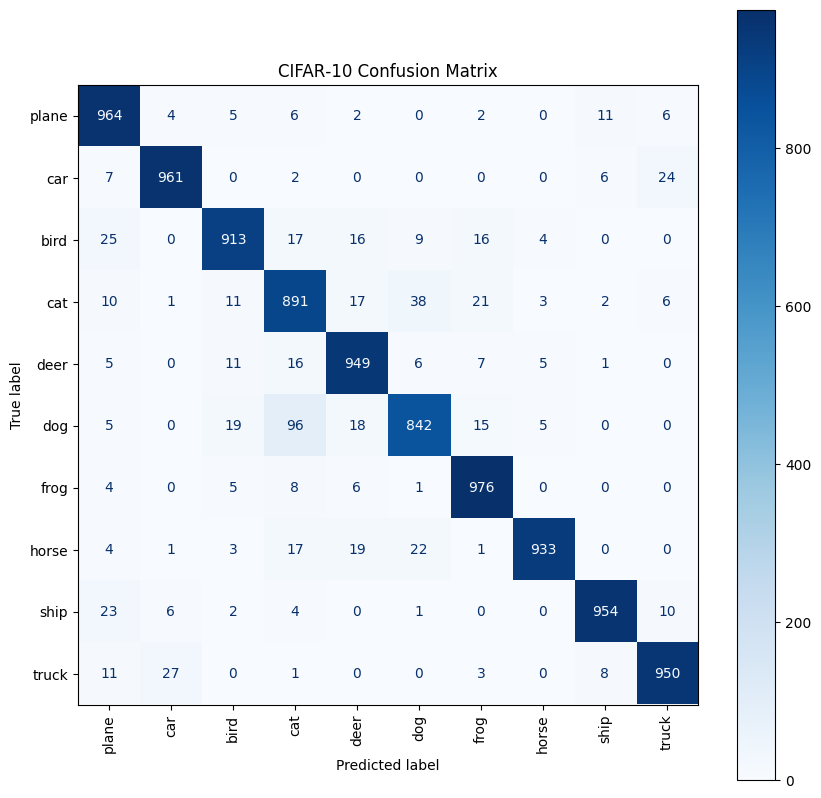

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.grid(False)
plt.show()


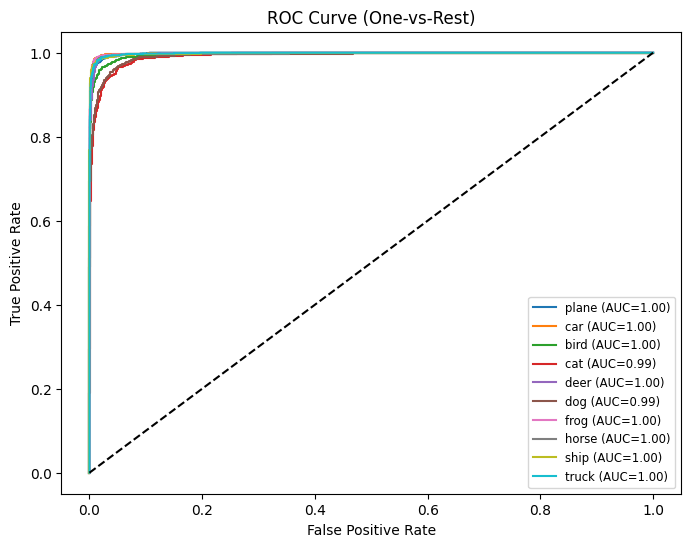

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(False)
plt.show()

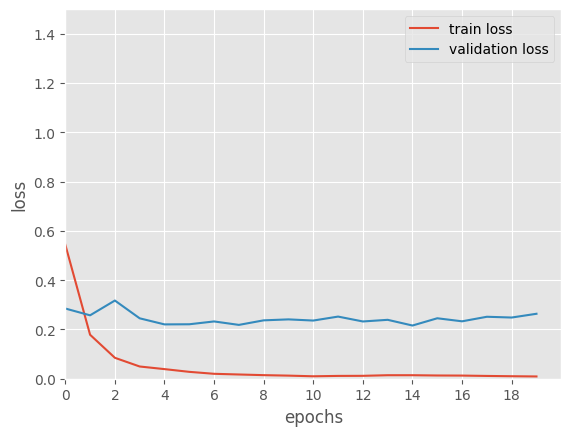

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0,20)
plt.ylim(0,1.5)
plt.xticks(range(0, 19, 2))
plt.legend()

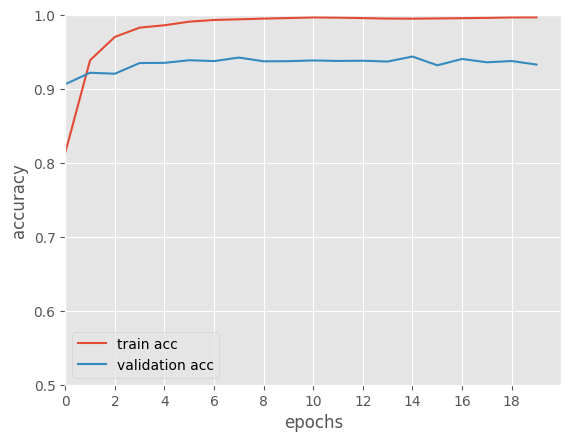

In [ ]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0,20)
plt.ylim(0.5,1)
plt.xticks(range(0, 19, 2))
plt.legend()

# Geometric Transformations

##Flip

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

raw_dataset =datasets.CIFAR10(root="./data", train=False, download=False, transform=None)
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float()).item()

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)

        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float()).item()

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

epoch: 0, loss: 0.6085025152633645, acc: 0.7895673384516955, val loss: 0.27080771827493044, val acc: 0.9075479233226837
epoch: 1, loss: 0.22504535925908875, acc: 0.9217250479846449, val loss: 0.21591383794221444, val acc: 0.9253194888178914
epoch: 2, loss: 0.137846107379267, acc: 0.9527551183621241, val loss: 0.19007361692766223, val acc: 0.93939696485623
epoch: 3, loss: 0.09532626757549595, acc: 0.9672304862444018, val loss: 0.2071908585602245, val acc: 0.9331070287539937
epoch: 4, loss: 0.06729765922326883, acc: 0.9771473128598849, val loss: 0.1872447619062905, val acc: 0.939297124600639
epoch: 5, loss: 0.05052450132132904, acc: 0.9836052463211772, val loss: 0.19300051832485338, val acc: 0.9409944089456869
epoch: 6, loss: 0.042125482020388856, acc: 0.985624600127959, val loss: 0.18388313511847712, val acc: 0.9455870607028753
epoch: 7, loss: 0.03544941612031132, acc: 0.9875039987204095, val loss: 0.1988436409263699, val acc: 0.944888178913738
epoch: 8, loss: 0.032125814383848685, acc:

Accuracy: 0.9463

Classification Report:
               precision    recall  f1-score   support

       plane     0.9641    0.9680    0.9661      1000
         car     0.9599    0.9810    0.9703      1000
        bird     0.9481    0.9500    0.9491      1000
         cat     0.8854    0.8650    0.8751      1000
        deer     0.9438    0.9400    0.9419      1000
         dog     0.8763    0.9210    0.8981      1000
        frog     0.9773    0.9490    0.9630      1000
       horse     0.9687    0.9600    0.9643      1000
        ship     0.9747    0.9640    0.9693      1000
       truck     0.9679    0.9650    0.9664      1000

    accuracy                         0.9463     10000
   macro avg     0.9466    0.9463    0.9464     10000
weighted avg     0.9466    0.9463    0.9464     10000



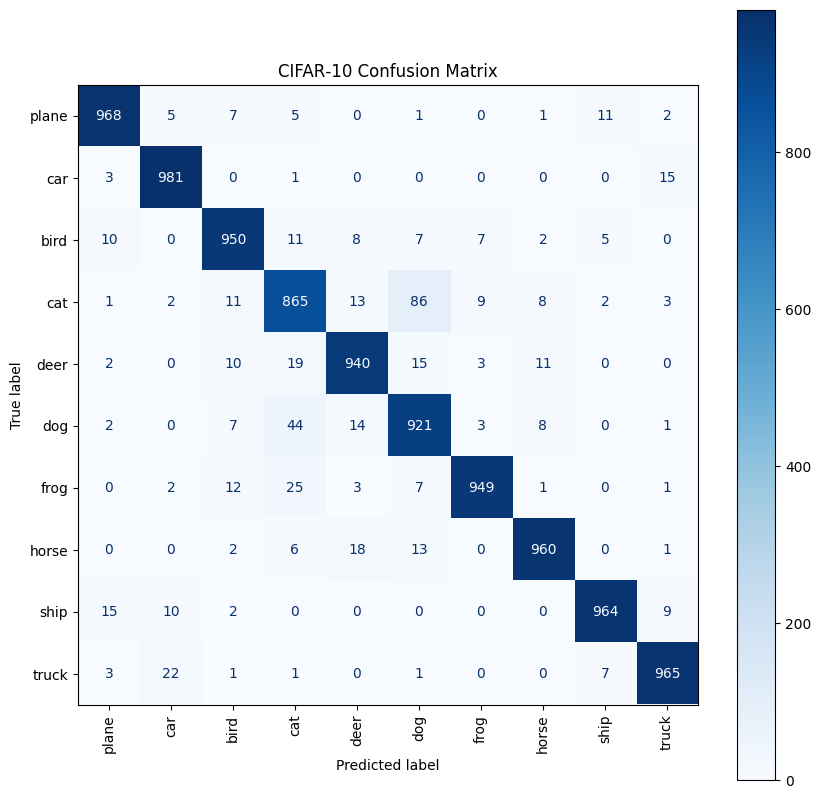

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.show()


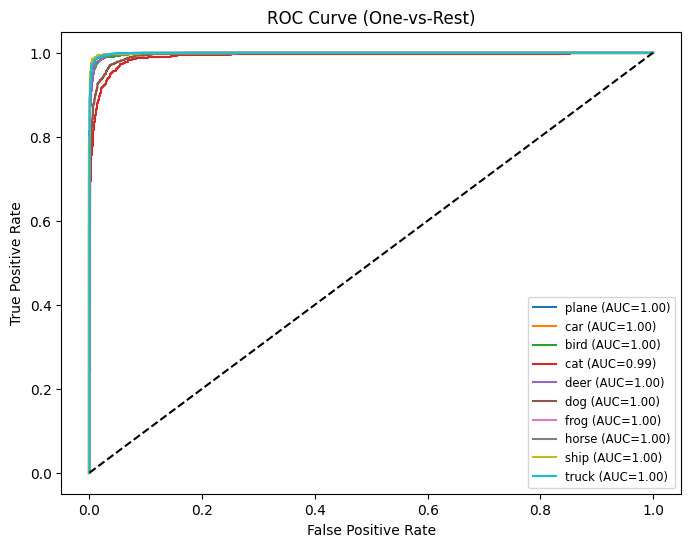

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.show()

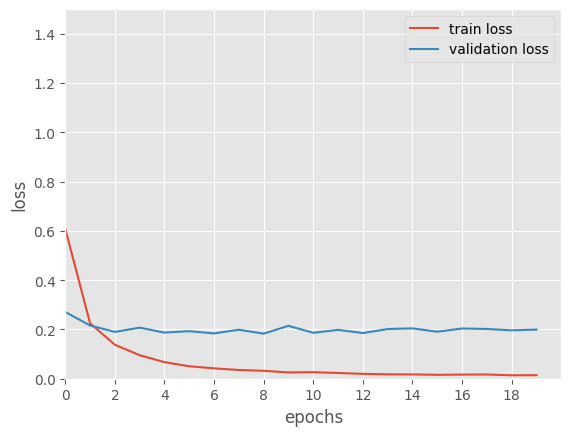

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0,20)
plt.ylim(0,1.5)
plt.xticks(range(0, 19, 2))
plt.legend()

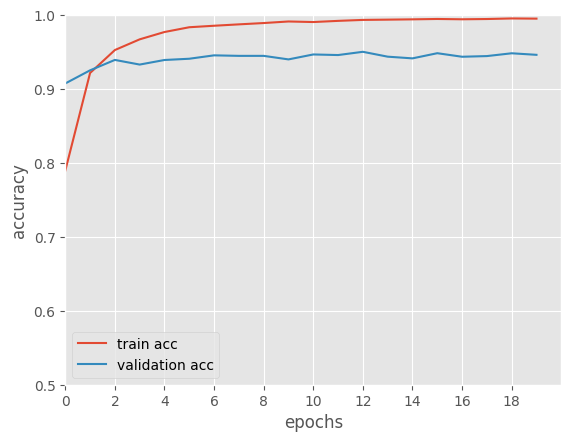

In [ ]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0,20)
plt.ylim(0.5,1)
plt.xticks(range(0, 19, 2))
plt.legend()

##Flip + Crop

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),          # Adds slight spatial jitter
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

raw_dataset =datasets.CIFAR10(root="./data", train=False, download=False, transform=None)
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)


conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.0.conv3.weight True
layer1.0.bn3.weight True
layer1.0.bn3.bias True
layer1.0.downsample.0.weight True
layer1.0.downsample.1.weight True
layer1.0.downsample.1.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer1.1.conv3.weight True
layer1.1.bn3.weight True
layer1.1.bn3.bias True
layer1.2.conv1.weight True
layer1.2.bn1.weight True
layer1.2.bn1.bias True
layer1.2.conv2.weight True
layer1.2.bn2.weight True
layer1.2.bn2.bias True
layer1.2.conv3.weight True
layer1.2.bn3.weight True
layer1.2.bn3.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.conv3.weight True


In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float()).item()

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)

        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float()).item()

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

epoch: 0, loss: 0.5228425924590552, acc: 0.819337811900192, val loss: 0.2407890701720033, val acc: 0.919229233226837
epoch: 1, loss: 0.2035344024013039, acc: 0.930602207293666, val loss: 0.16688102497734106, val acc: 0.9417931309904153
epoch: 2, loss: 0.13876723590746678, acc: 0.9522552783109405, val loss: 0.16104889164467495, val acc: 0.9446884984025559
epoch: 3, loss: 0.11045462199828217, acc: 0.9604326615483045, val loss: 0.15920045201000146, val acc: 0.9476837060702875
epoch: 4, loss: 0.0948519836580923, acc: 0.967530390275112, val loss: 0.13368629381364097, val acc: 0.9555710862619808
epoch: 5, loss: 0.0796297499165922, acc: 0.9726687460012796, val loss: 0.13695176273990517, val acc: 0.9551717252396166
epoch: 6, loss: 0.06787304476186394, acc: 0.9765275111964171, val loss: 0.14948189089419886, val acc: 0.9524760383386581
epoch: 7, loss: 0.056528162653919196, acc: 0.9809660908509277, val loss: 0.14573305020236765, val acc: 0.9533746006389776
epoch: 8, loss: 0.0528284202005762, acc:

Accuracy: 0.9564

Classification Report:
               precision    recall  f1-score   support

       plane     0.9729    0.9680    0.9704      1000
         car     0.9741    0.9770    0.9755      1000
        bird     0.9447    0.9560    0.9503      1000
         cat     0.9236    0.8830    0.9029      1000
        deer     0.9317    0.9680    0.9495      1000
         dog     0.9203    0.9240    0.9222      1000
        frog     0.9760    0.9770    0.9765      1000
       horse     0.9807    0.9670    0.9738      1000
        ship     0.9713    0.9810    0.9761      1000
       truck     0.9688    0.9630    0.9659      1000

    accuracy                         0.9564     10000
   macro avg     0.9564    0.9564    0.9563     10000
weighted avg     0.9564    0.9564    0.9563     10000



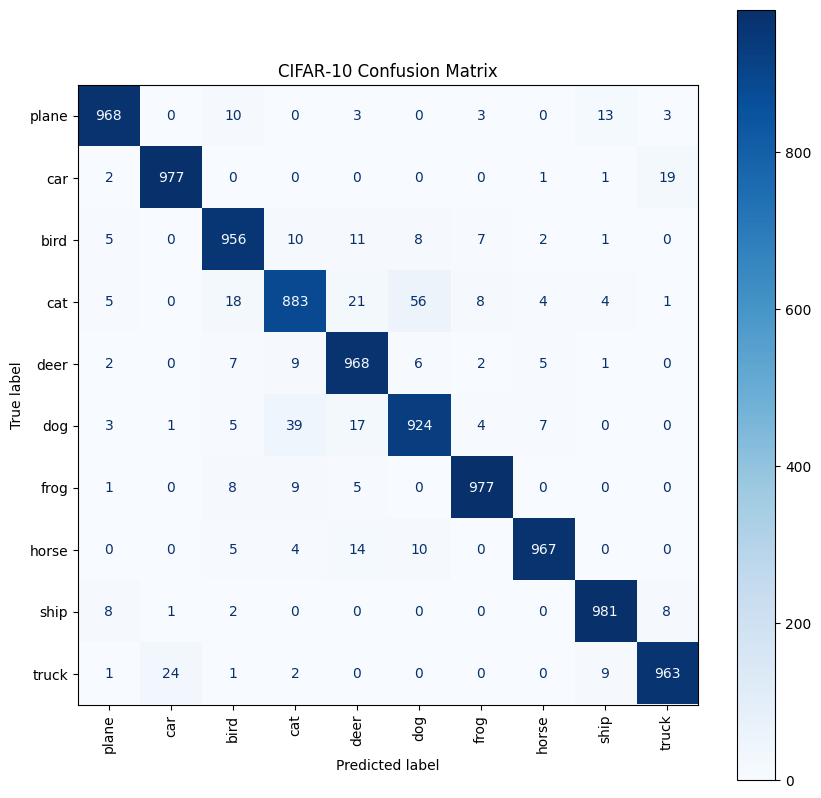

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.show()


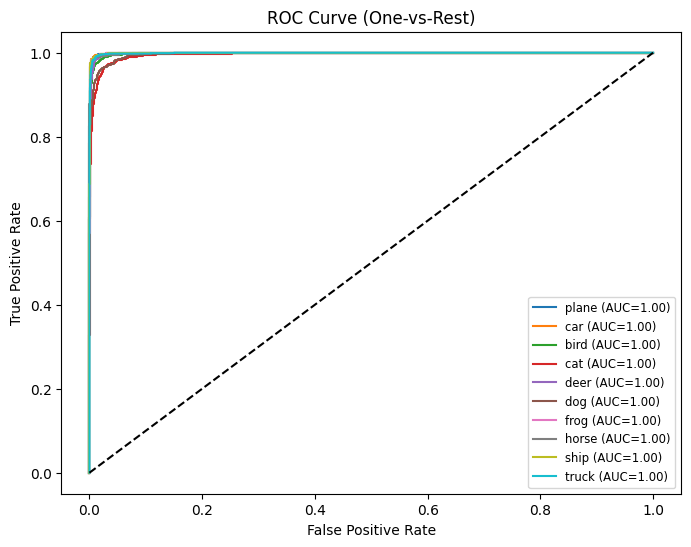

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.show()

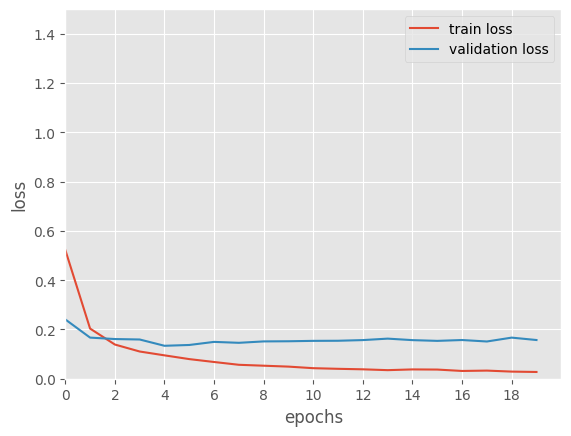

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0,20)
plt.ylim(0,1.5)
plt.xticks(range(0, 19, 2))
plt.legend()

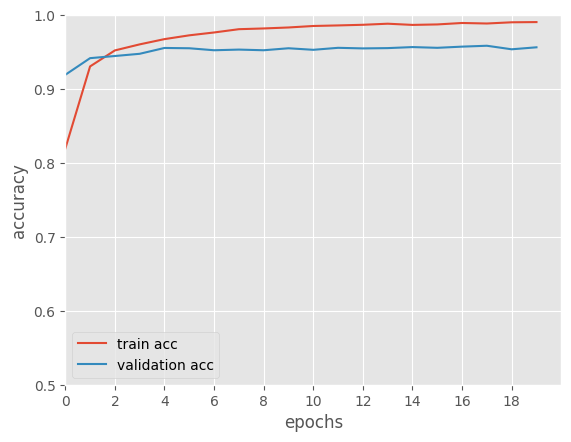

In [ ]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0,20)
plt.ylim(0.5,1)
plt.xticks(range(0, 19, 2))
plt.legend()

##Flip + Crop+Rotation(10)

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),          # Adds slight spatial jitter
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

raw_dataset =datasets.CIFAR10(root="./data", train=False, download=True, transform=None)
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float()).item()

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)

        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float()).item()

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

epoch: 0, loss: 0.7203252085377906, acc: 0.7504198656429942, val loss: 0.2944700506012946, val acc: 0.9004592651757188
epoch: 1, loss: 0.3151257391172918, acc: 0.8913347728726807, val loss: 0.20320441019974245, val acc: 0.9308107028753994
epoch: 2, loss: 0.23186351413351752, acc: 0.9192458413307741, val loss: 0.1918317469211813, val acc: 0.9366014376996805
epoch: 3, loss: 0.19153435240182085, acc: 0.9349608125399872, val loss: 0.16506727179214833, val acc: 0.9444888178913738
epoch: 4, loss: 0.15670801730920642, acc: 0.9460372680742163, val loss: 0.1582792456092212, val acc: 0.9468849840255591
epoch: 5, loss: 0.13627124031956808, acc: 0.9523552463211772, val loss: 0.16187331521104034, val acc: 0.9463857827476039
epoch: 6, loss: 0.12196009347596047, acc: 0.9576735444657709, val loss: 0.16699470394996171, val acc: 0.946685303514377
epoch: 7, loss: 0.1061658139611098, acc: 0.9632117722328855, val loss: 0.15363147614610057, val acc: 0.9528753993610224
epoch: 8, loss: 0.10158806995107951, ac

Accuracy: 0.9511

Classification Report:
               precision    recall  f1-score   support

       plane     0.9791    0.9390    0.9587      1000
         car     0.9778    0.9670    0.9723      1000
        bird     0.9559    0.9320    0.9438      1000
         cat     0.8832    0.9070    0.8949      1000
        deer     0.9382    0.9710    0.9543      1000
         dog     0.9304    0.9090    0.9196      1000
        frog     0.9698    0.9620    0.9659      1000
       horse     0.9710    0.9720    0.9715      1000
        ship     0.9435    0.9850    0.9638      1000
       truck     0.9660    0.9670    0.9665      1000

    accuracy                         0.9511     10000
   macro avg     0.9515    0.9511    0.9511     10000
weighted avg     0.9515    0.9511    0.9511     10000



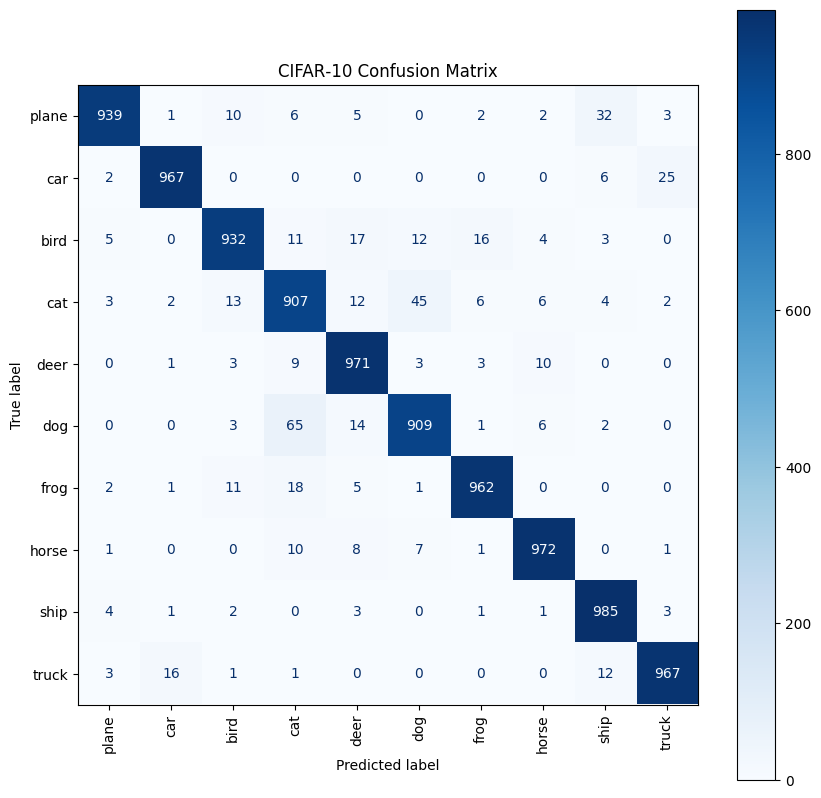

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.show()


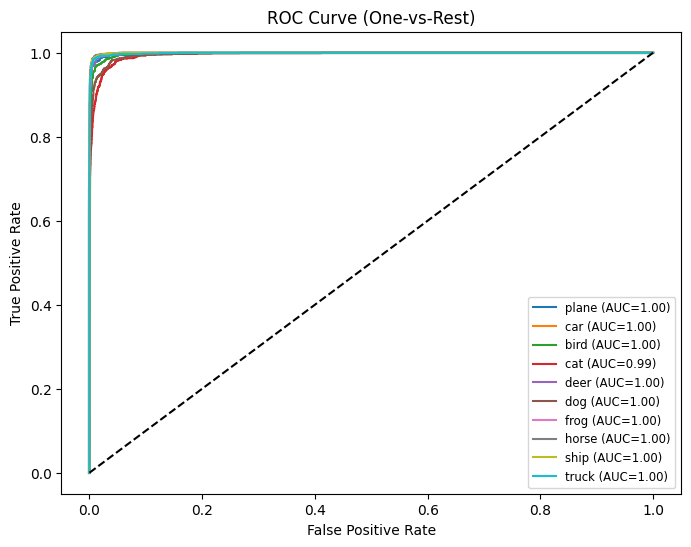

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.show()

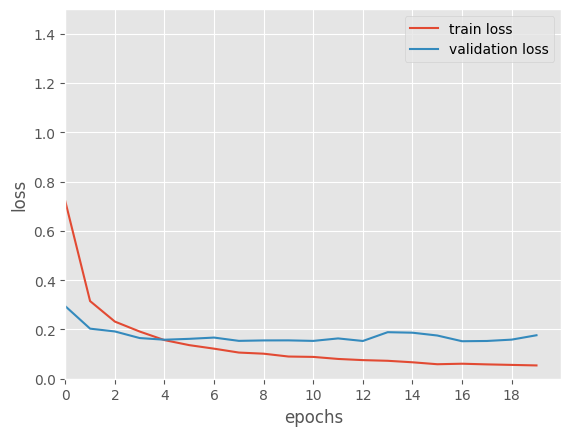

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0,20)
plt.ylim(0,1.5)
plt.xticks(range(0, 19, 2))
plt.legend()

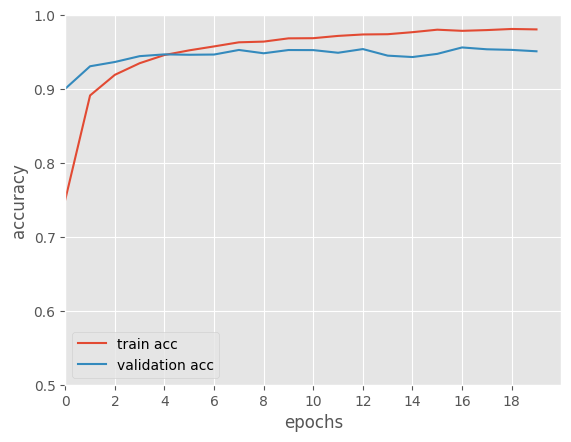

In [ ]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0,20)
plt.ylim(0.5,1)
plt.xticks(range(0, 19, 2))
plt.legend()

#Color Transformation

##Flip + Crop + Rotation + Gausian

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

raw_dataset =datasets.CIFAR10(root="./data", train=False, download=True, transform=None)
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float()).item()

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)

        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float()).item()

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

epoch: 0, loss: 0.903036478051221, acc: 0.6820217530390275, val loss: 0.3473071395612944, val acc: 0.8797923322683706
epoch: 1, loss: 0.3877739557306391, acc: 0.8694617722328855, val loss: 0.22413447047003543, val acc: 0.9237220447284346
epoch: 2, loss: 0.28813716032979053, acc: 0.9006118042226487, val loss: 0.1955715644235809, val acc: 0.931908945686901
epoch: 3, loss: 0.2337135604165032, acc: 0.9194257837492003, val loss: 0.1760596477221281, val acc: 0.941194089456869
epoch: 4, loss: 0.20393926405150656, acc: 0.9292226487523992, val loss: 0.16683574124185827, val acc: 0.9420926517571885
epoch: 5, loss: 0.17941156693395185, acc: 0.9378198976327575, val loss: 0.15431817928507638, val acc: 0.946685303514377
epoch: 6, loss: 0.1570874163836255, acc: 0.945677383237364, val loss: 0.14665492838203978, val acc: 0.9514776357827476
epoch: 7, loss: 0.14429856581233266, acc: 0.9495761356365963, val loss: 0.148123857543652, val acc: 0.952276357827476
epoch: 8, loss: 0.13408065708687794, acc: 0.953

Accuracy: 0.9498

Classification Report:
               precision    recall  f1-score   support

       plane     0.9745    0.9550    0.9646      1000
         car     0.9464    0.9890    0.9672      1000
        bird     0.9424    0.9490    0.9457      1000
         cat     0.8467    0.9280    0.8855      1000
        deer     0.9645    0.9510    0.9577      1000
         dog     0.9248    0.8860    0.9050      1000
        frog     0.9835    0.9510    0.9670      1000
       horse     0.9818    0.9700    0.9759      1000
        ship     0.9750    0.9770    0.9760      1000
       truck     0.9701    0.9420    0.9559      1000

    accuracy                         0.9498     10000
   macro avg     0.9510    0.9498    0.9500     10000
weighted avg     0.9510    0.9498    0.9500     10000



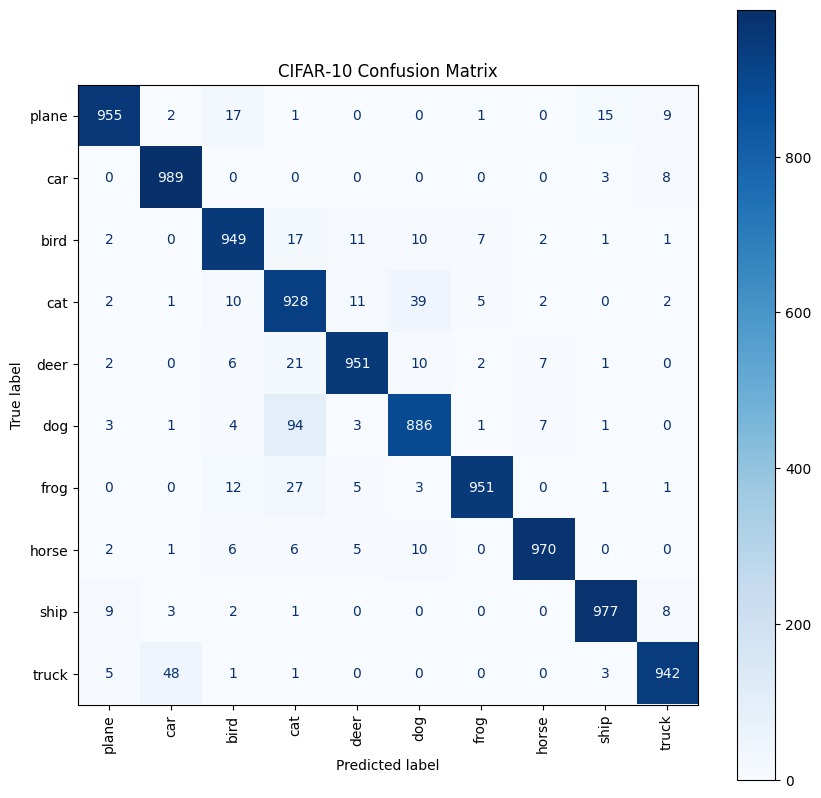

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.grid(False)
plt.show()


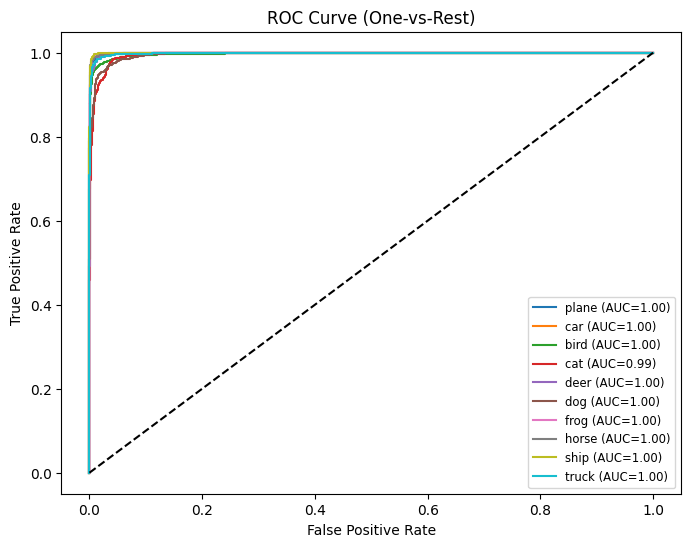

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.show()

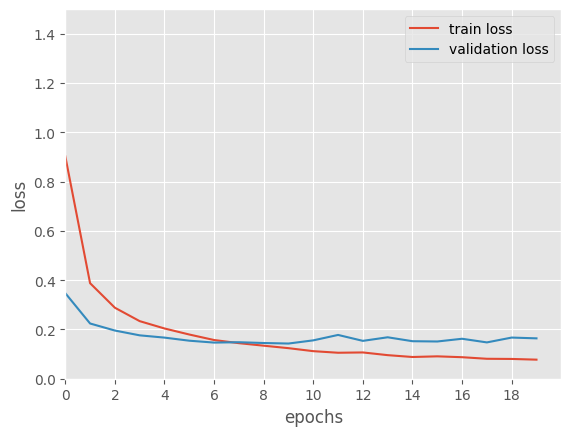

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0,20)
plt.ylim(0,1.5)
plt.xticks(range(0, 19, 2))
plt.legend()

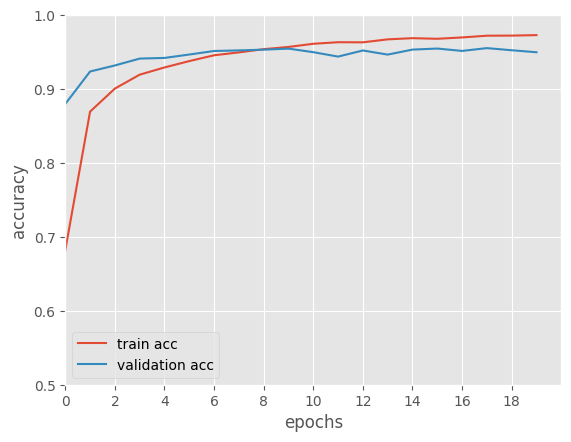

In [ ]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0,20)
plt.ylim(0.5,1)
plt.xticks(range(0, 19, 2))
plt.legend()

#Mixup

##Mixup 0.2

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

raw_dataset =datasets.CIFAR10(root="./data", train=False, download=True, transform=None)
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
# def mixup_data(x, y, alpha=1.0):
#     if alpha > 0:
#         lam = np.random.beta(alpha, alpha)
#     else:
#         lam = 1

#     batch_size = x.size()[0]
#     index = torch.randperm(batch_size).cuda()

#     mixed_x = lam * x + (1 - lam) * x[index, :]
#     y_a, y_b = y, y[index]
#     return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
from torch.autograd import Variable
from tqdm import tqdm

num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in tqdm(train_dataloader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        lam = np.random.beta(0.2, 0.2)
        perm = torch.randperm(imgs.size(0)).to(device)

        mixed_imgs = lam * imgs + (1 - lam) * imgs[perm]
        targets_a = labels
        targets_b = labels[perm]

        # img, targets_a, targets_b, lam = mixup_data(imgs, labels,
        #                                                args.alpha)
        # imgs, targets_a, targets_b = map(Variable, (imgs,
        #                                               targets_a, targets_b))
        optimizer.zero_grad()
        output = model(mixed_imgs)
        loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        correct = lam * pred.eq(targets_a).float().mean() + (1 - lam) * pred.eq(targets_b).float().mean()
        running_acc += correct

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float()).item()

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

100%|██████████| 1563/1563 [01:17<00:00, 20.14it/s]


epoch: 0, loss: 1.0541985680373602, acc: 0.6691197752952576, val loss: 0.4389664024685899, val acc: 0.8722044728434505


100%|██████████| 1563/1563 [01:16<00:00, 20.47it/s]


epoch: 1, loss: 0.6368353156228708, acc: 0.8246506452560425, val loss: 0.37619230622491134, val acc: 0.9109424920127795


100%|██████████| 1563/1563 [01:15<00:00, 20.63it/s]


epoch: 2, loss: 0.5340848024451887, acc: 0.8603505492210388, val loss: 0.31418001454192607, val acc: 0.9232228434504792


100%|██████████| 1563/1563 [01:16<00:00, 20.44it/s]


epoch: 3, loss: 0.5102923210967697, acc: 0.8697835206985474, val loss: 0.33967634050038675, val acc: 0.9284145367412141


100%|██████████| 1563/1563 [01:15<00:00, 20.60it/s]


epoch: 4, loss: 0.48191542348062344, acc: 0.8803449869155884, val loss: 0.3155873942489441, val acc: 0.9261182108626198


100%|██████████| 1563/1563 [01:16<00:00, 20.55it/s]


epoch: 5, loss: 0.46221153645501223, acc: 0.8838400840759277, val loss: 0.23470217779802438, val acc: 0.9394968051118211


100%|██████████| 1563/1563 [01:15<00:00, 20.62it/s]


epoch: 6, loss: 0.4530502004118104, acc: 0.8862422704696655, val loss: 0.24434906598954156, val acc: 0.9412939297124601


100%|██████████| 1563/1563 [01:15<00:00, 20.66it/s]


epoch: 7, loss: 0.43332473592867243, acc: 0.8936544060707092, val loss: 0.20398153815739833, val acc: 0.9455870607028753


100%|██████████| 1563/1563 [01:15<00:00, 20.65it/s]


epoch: 8, loss: 0.43703060198672977, acc: 0.8917543888092041, val loss: 0.2733259407190469, val acc: 0.9413937699680511


100%|██████████| 1563/1563 [01:15<00:00, 20.59it/s]


epoch: 9, loss: 0.4434924898193929, acc: 0.8889680504798889, val loss: 0.2850114488706421, val acc: 0.9364017571884984


100%|██████████| 1563/1563 [01:16<00:00, 20.52it/s]


epoch: 10, loss: 0.42253936249187773, acc: 0.8948178291320801, val loss: 0.2388995598299435, val acc: 0.9463857827476039


100%|██████████| 1563/1563 [01:16<00:00, 20.51it/s]


epoch: 11, loss: 0.41693231890482146, acc: 0.8940646648406982, val loss: 0.22064144590411322, val acc: 0.9482827476038339


100%|██████████| 1563/1563 [01:16<00:00, 20.43it/s]


epoch: 12, loss: 0.41760519246173927, acc: 0.8948463797569275, val loss: 0.22720128992875924, val acc: 0.9469848242811502


100%|██████████| 1563/1563 [01:16<00:00, 20.52it/s]


epoch: 13, loss: 0.4077855806627328, acc: 0.8972254395484924, val loss: 0.18852263109419293, val acc: 0.9490814696485623


100%|██████████| 1563/1563 [01:16<00:00, 20.47it/s]


epoch: 14, loss: 0.4149639054301498, acc: 0.8934048414230347, val loss: 0.38379306707995386, val acc: 0.9241214057507987


100%|██████████| 1563/1563 [01:16<00:00, 20.47it/s]


epoch: 15, loss: 0.40295550545262826, acc: 0.8974247574806213, val loss: 0.3059299101773352, val acc: 0.9416932907348243


100%|██████████| 1563/1563 [01:15<00:00, 20.59it/s]


epoch: 16, loss: 0.4166108453874962, acc: 0.8935738205909729, val loss: 0.21072388424898109, val acc: 0.9438897763578274


100%|██████████| 1563/1563 [01:15<00:00, 20.59it/s]


epoch: 17, loss: 0.3903840226632938, acc: 0.9012171030044556, val loss: 0.1779158771597444, val acc: 0.9517771565495208


100%|██████████| 1563/1563 [01:16<00:00, 20.54it/s]


epoch: 18, loss: 0.4173321507740659, acc: 0.8921542763710022, val loss: 0.27022930821433616, val acc: 0.9415934504792333


100%|██████████| 1563/1563 [01:16<00:00, 20.50it/s]


epoch: 19, loss: 0.4169516035563283, acc: 0.8911629319190979, val loss: 0.2145582445013447, val acc: 0.9498801916932907
Accuracy       : 0.9499
Precision (macro): 0.9502
Recall (macro)   : 0.9499
F1 Score (macro): 0.9499


Accuracy: 0.9499

Classification Report:
               precision    recall  f1-score   support

       plane     0.9591    0.9610    0.9600      1000
         car     0.9336    0.9850    0.9586      1000
        bird     0.9527    0.9460    0.9493      1000
         cat     0.8949    0.8940    0.8944      1000
        deer     0.9538    0.9490    0.9514      1000
         dog     0.9117    0.9190    0.9153      1000
        frog     0.9736    0.9580    0.9657      1000
       horse     0.9695    0.9550    0.9622      1000
        ship     0.9732    0.9800    0.9766      1000
       truck     0.9794    0.9520    0.9655      1000

    accuracy                         0.9499     10000
   macro avg     0.9502    0.9499    0.9499     10000
weighted avg     0.9502    0.9499    0.9499     10000



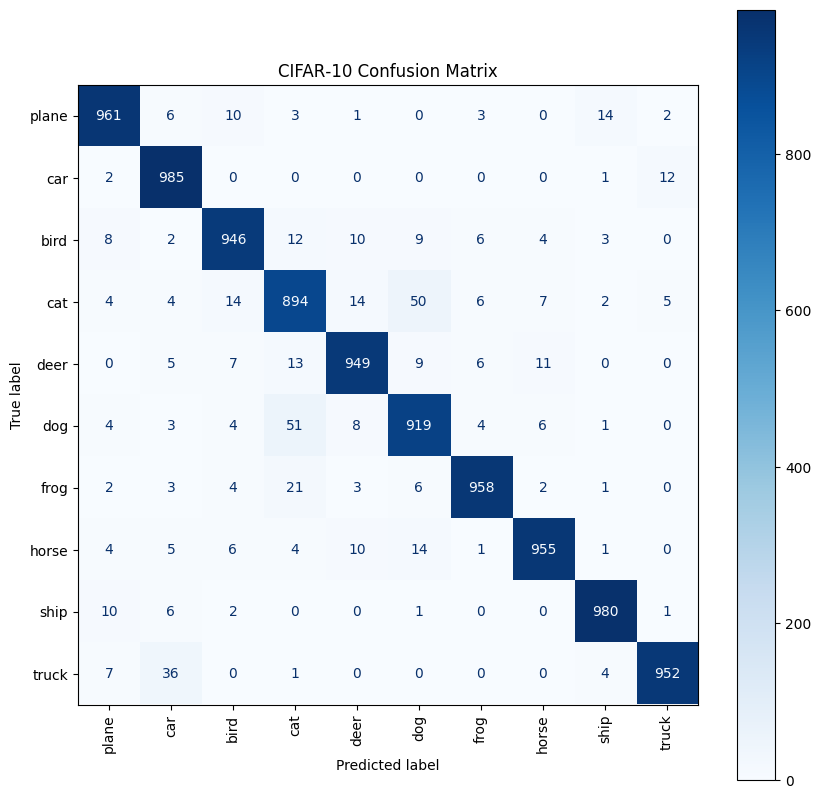

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.show()


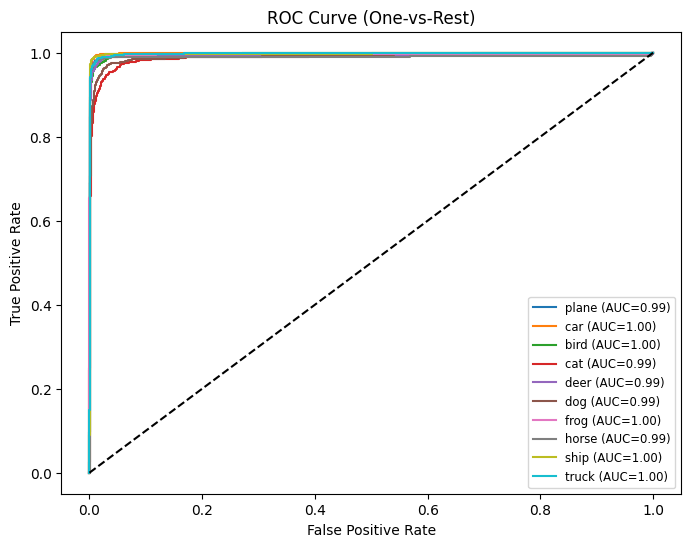

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.show()

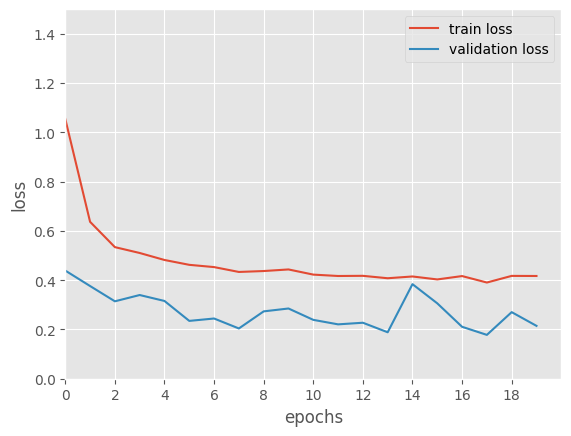

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0,20)
plt.ylim(0,1.5)
plt.xticks(range(0, 19, 2))
plt.legend()

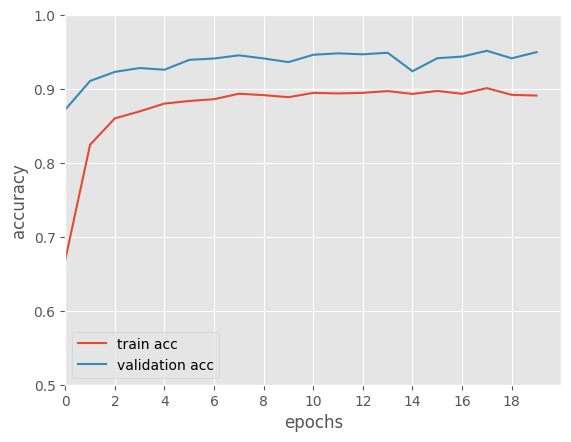

In [ ]:
plt.plot([accs_.cpu() for accs_ in accs], label="train acc")
plt.plot(val_accs, label="validation acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0,20)
plt.ylim(0.5,1)
plt.xticks(range(0, 19, 2))
plt.legend()

# Strong
ZCA+GCN+Flip+Rotation+Gausian

## ZCA+GCN+Flip+Rotation+Gausian

In [ ]:
class gcn():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ


# 標準化後の画像を[0, 1]に正規化する
def deprocess(x):
    _min = np.min(x)
    _max = np.max(x)
    _x = (x - _min)/(_max - _min)
    return _x

In [ ]:
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        x = images[0][0].reshape(1, -1)  # 画像（1枚）を1次元化
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)  # 平均値を格納するテンソル．xと同じ形状
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        # E: 固有値 V: 固有ベクトルを並べたもの
        E, V = torch.linalg.eigh(con_matrix)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())  # A(\Lambda + \epsilon I)^{1/2}A^T
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean  # x - \bar{x}
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x

zca = ZCAWhitening()
raw_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
zca.fit(raw_dataset)

GCN = gcn()


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    GCN,
    zca,
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    GCN,
    zca,
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

raw_dataset =datasets.CIFAR10(root="./data", train=False, download=True, transform=None)
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)


    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))
    scheduler.step()

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

epoch: 0, loss: 0.8350435046149002, acc: 0.7071537375450134, val loss: 0.3799308740768951, val acc: 0.8691093921661377
epoch: 1, loss: 0.41143270709712154, acc: 0.8584852814674377, val loss: 0.2633828096115551, val acc: 0.9109424948692322
epoch: 2, loss: 0.30991052757050086, acc: 0.8933741450309753, val loss: 0.23667844081410586, val acc: 0.9175319075584412
epoch: 3, loss: 0.25160039255606464, acc: 0.9123680591583252, val loss: 0.20649879435285592, val acc: 0.9272164106369019
epoch: 4, loss: 0.20488321505366602, acc: 0.9297224879264832, val loss: 0.2061845745546178, val acc: 0.9278154969215393
epoch: 5, loss: 0.1727342747922889, acc: 0.9399392008781433, val loss: 0.18158807198311716, val acc: 0.9374001622200012
epoch: 6, loss: 0.14208614862579388, acc: 0.950755774974823, val loss: 0.19267097832902838, val acc: 0.9366014003753662
epoch: 7, loss: 0.12146336625592923, acc: 0.9586332440376282, val loss: 0.1822849892239018, val acc: 0.940095841884613
epoch: 8, loss: 0.1003380101054945, acc:

Accuracy: 0.9581

Classification Report:
               precision    recall  f1-score   support

       plane     0.9657    0.9570    0.9613      1000
         car     0.9702    0.9760    0.9731      1000
        bird     0.9436    0.9530    0.9483      1000
         cat     0.9067    0.9140    0.9104      1000
        deer     0.9686    0.9560    0.9623      1000
         dog     0.9357    0.9310    0.9333      1000
        frog     0.9741    0.9760    0.9750      1000
       horse     0.9760    0.9740    0.9750      1000
        ship     0.9750    0.9740    0.9745      1000
       truck     0.9661    0.9700    0.9681      1000

    accuracy                         0.9581     10000
   macro avg     0.9582    0.9581    0.9581     10000
weighted avg     0.9582    0.9581    0.9581     10000



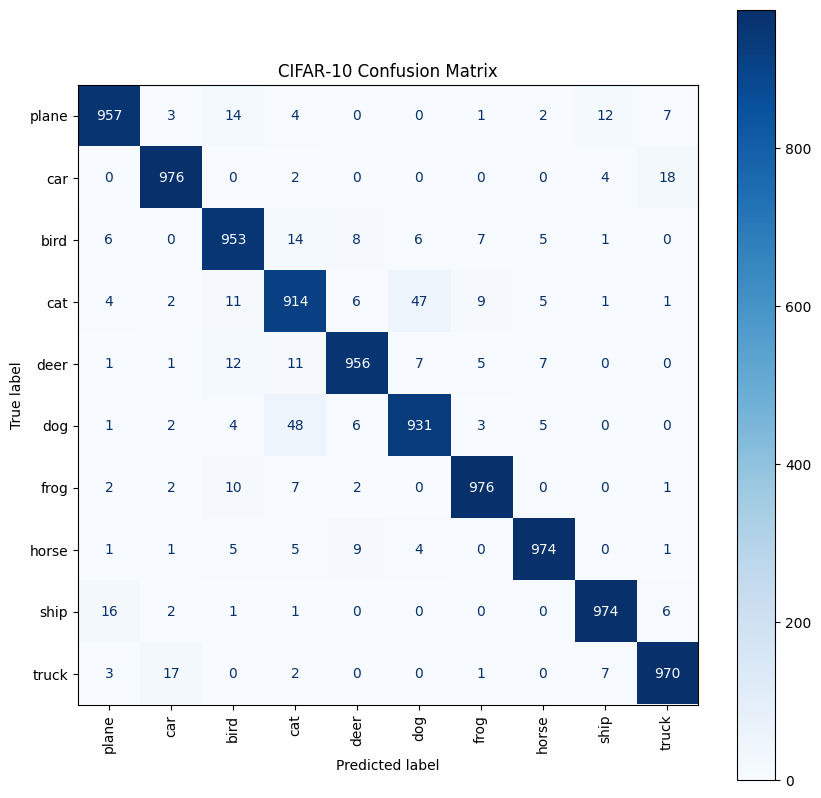

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.show()

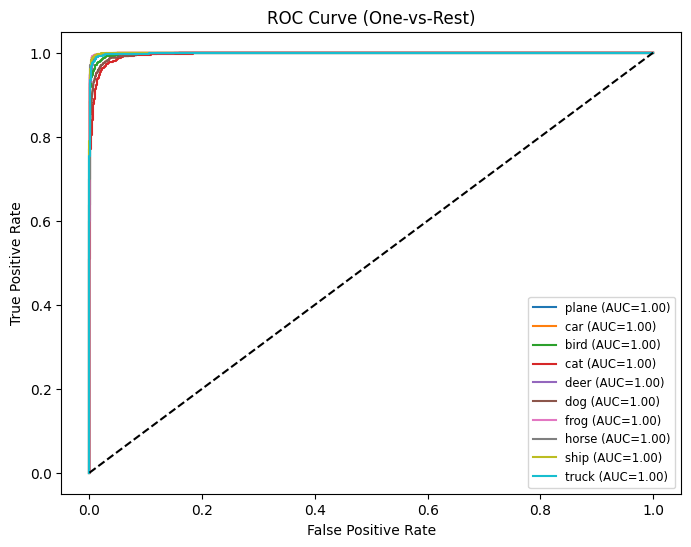

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.show()

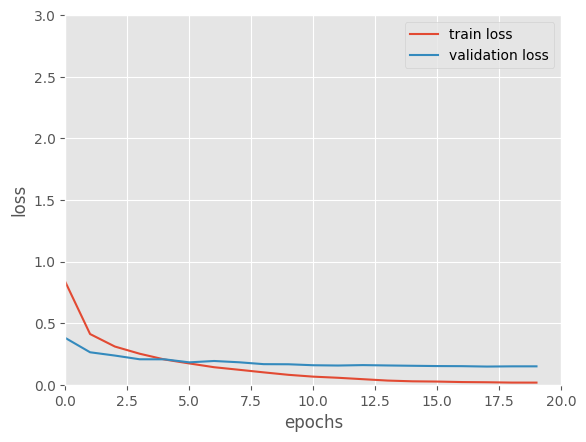

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0,20)
plt.ylim(0,3)
plt.legend()

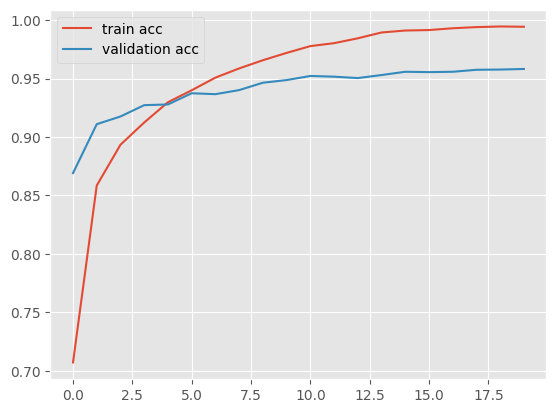

In [ ]:
plt.plot([accs_.cpu() for accs_ in accs], label="train acc")
plt.plot([accs_.cpu() for accs_ in val_accs], label="validation acc")
plt.legend()

In [ ]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


## ZCA + Flip+ Crop + Rotation 10 + Mixup 0.2

In [ ]:
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        x = images[0][0].reshape(1, -1)  # 画像（1枚）を1次元化
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)  # 平均値を格納するテンソル．xと同じ形状
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        # E: 固有値 V: 固有ベクトルを並べたもの
        E, V = torch.linalg.eigh(con_matrix)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())  # A(\Lambda + \epsilon I)^{1/2}A^T
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean  # x - \bar{x}
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x

zca = ZCAWhitening()
raw_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
zca.fit(raw_dataset)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    zca
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    zca
])

raw_dataset =datasets.CIFAR10(root="./data", train=False, download=True, transform=None)
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
from torch.autograd import Variable
from tqdm import tqdm
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in tqdm(train_dataloader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        lam = np.random.beta(0.2, 0.2)
        perm = torch.randperm(imgs.size(0)).to(device)

        mixed_imgs = lam * imgs + (1 - lam) * imgs[perm]
        targets_a = labels
        targets_b = labels[perm]

        optimizer.zero_grad()
        output = model(mixed_imgs)
        loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        correct = lam * pred.eq(targets_a).float().mean() + (1 - lam) * pred.eq(targets_b).float().mean()
        running_acc += correct

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float()).item()

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)


    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))
    scheduler.step()

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

100%|██████████| 1563/1563 [01:39<00:00, 15.74it/s]


epoch: 0, loss: 1.1204147020441861, acc: 0.6427173614501953, val loss: 0.4559572777047325, val acc: 0.8698083067092651


100%|██████████| 1563/1563 [01:39<00:00, 15.70it/s]


epoch: 1, loss: 0.8053234019772563, acc: 0.7636549472808838, val loss: 0.3246387013802513, val acc: 0.9038538338658147


100%|██████████| 1563/1563 [01:38<00:00, 15.83it/s]


epoch: 2, loss: 0.708429072202396, acc: 0.7967315912246704, val loss: 0.29997629926989255, val acc: 0.915535143769968


100%|██████████| 1563/1563 [01:38<00:00, 15.81it/s]


epoch: 3, loss: 0.6573924583872102, acc: 0.8124181628227234, val loss: 0.27156310711805814, val acc: 0.9288138977635783


100%|██████████| 1563/1563 [01:39<00:00, 15.79it/s]


epoch: 4, loss: 0.6212598677803253, acc: 0.8264628648757935, val loss: 0.23074290903802877, val acc: 0.9268170926517572


100%|██████████| 1563/1563 [01:39<00:00, 15.72it/s]


epoch: 5, loss: 0.6045342857174227, acc: 0.8341353535652161, val loss: 0.20989570622674572, val acc: 0.9379992012779552


100%|██████████| 1563/1563 [01:39<00:00, 15.72it/s]


epoch: 6, loss: 0.5733226686823334, acc: 0.8432618975639343, val loss: 0.2133464885833926, val acc: 0.9370007987220448


100%|██████████| 1563/1563 [01:39<00:00, 15.78it/s]


epoch: 7, loss: 0.5570388468791584, acc: 0.8497711420059204, val loss: 0.21579640478895495, val acc: 0.9396964856230032


100%|██████████| 1563/1563 [01:39<00:00, 15.77it/s]


epoch: 8, loss: 0.522388772412739, acc: 0.8618195056915283, val loss: 0.20534215220056784, val acc: 0.9417931309904153


100%|██████████| 1563/1563 [01:38<00:00, 15.82it/s]


epoch: 9, loss: 0.5189136991852934, acc: 0.862176239490509, val loss: 0.1683807516434846, val acc: 0.9461861022364217


100%|██████████| 1563/1563 [01:39<00:00, 15.72it/s]


epoch: 10, loss: 0.49864800695701716, acc: 0.8679924011230469, val loss: 0.17055666366943156, val acc: 0.9490814696485623


100%|██████████| 1563/1563 [01:39<00:00, 15.77it/s]


epoch: 11, loss: 0.4910052671301002, acc: 0.8712613582611084, val loss: 0.1683288023066216, val acc: 0.952176517571885


100%|██████████| 1563/1563 [01:38<00:00, 15.82it/s]


epoch: 12, loss: 0.4918081861138892, acc: 0.8721219897270203, val loss: 0.21932925500523168, val acc: 0.952076677316294


100%|██████████| 1563/1563 [01:39<00:00, 15.78it/s]


epoch: 13, loss: 0.46717596287026963, acc: 0.8800175189971924, val loss: 0.1570970300858775, val acc: 0.9533746006389776


100%|██████████| 1563/1563 [01:39<00:00, 15.79it/s]


epoch: 14, loss: 0.4452719105650705, acc: 0.8872457146644592, val loss: 0.1672726691768954, val acc: 0.9562699680511182


100%|██████████| 1563/1563 [01:39<00:00, 15.75it/s]


epoch: 15, loss: 0.4498454365606395, acc: 0.885678231716156, val loss: 0.17753249984056044, val acc: 0.9569688498402555


100%|██████████| 1563/1563 [01:39<00:00, 15.77it/s]


epoch: 16, loss: 0.44222234198120464, acc: 0.8880918025970459, val loss: 0.15813418107625013, val acc: 0.957867412140575


100%|██████████| 1563/1563 [01:39<00:00, 15.75it/s]


epoch: 17, loss: 0.45488560950203, acc: 0.8842794299125671, val loss: 0.15416542357339647, val acc: 0.957667731629393


100%|██████████| 1563/1563 [01:38<00:00, 15.86it/s]


epoch: 18, loss: 0.4341944584550583, acc: 0.8905723690986633, val loss: 0.14042876951824934, val acc: 0.9589656549520766


100%|██████████| 1563/1563 [01:39<00:00, 15.78it/s]


epoch: 19, loss: 0.4559632295987528, acc: 0.8849982023239136, val loss: 0.22788872579320932, val acc: 0.9568690095846646
Accuracy       : 0.9569
Precision (macro): 0.9570
Recall (macro)   : 0.9569
F1 Score (macro): 0.9569


Accuracy: 0.9569

Classification Report:
               precision    recall  f1-score   support

       plane     0.9557    0.9700    0.9628      1000
         car     0.9618    0.9820    0.9718      1000
        bird     0.9411    0.9580    0.9495      1000
         cat     0.9046    0.9010    0.9028      1000
        deer     0.9794    0.9520    0.9655      1000
         dog     0.9239    0.9230    0.9235      1000
        frog     0.9780    0.9790    0.9785      1000
       horse     0.9750    0.9760    0.9755      1000
        ship     0.9787    0.9650    0.9718      1000
       truck     0.9717    0.9630    0.9674      1000

    accuracy                         0.9569     10000
   macro avg     0.9570    0.9569    0.9569     10000
weighted avg     0.9570    0.9569    0.9569     10000



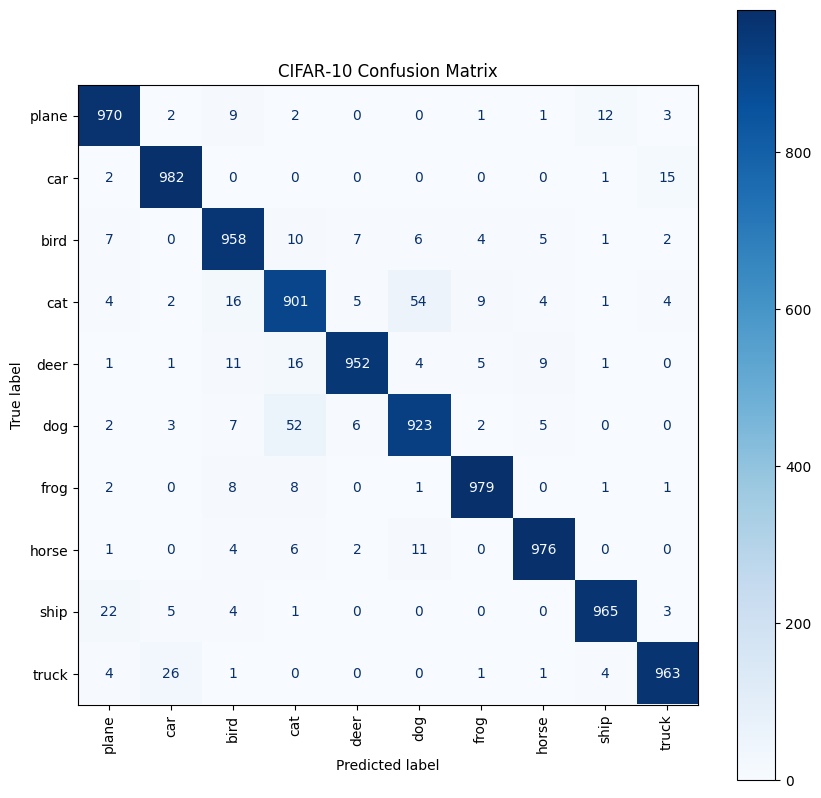

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.show()

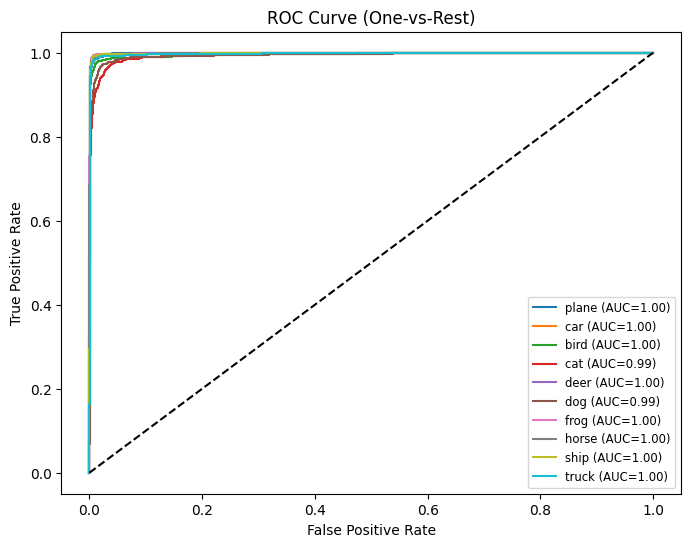

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.show()

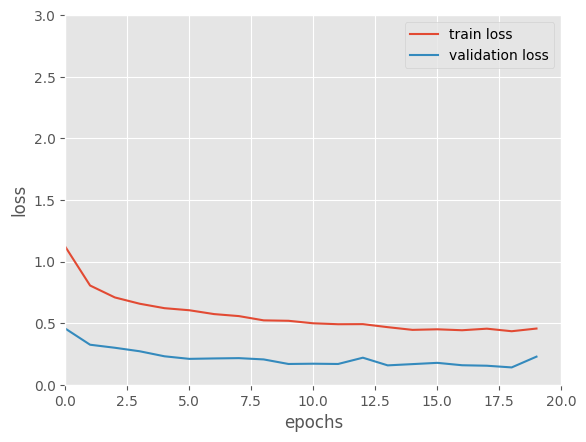

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0,20)
plt.ylim(0,3)
plt.legend()

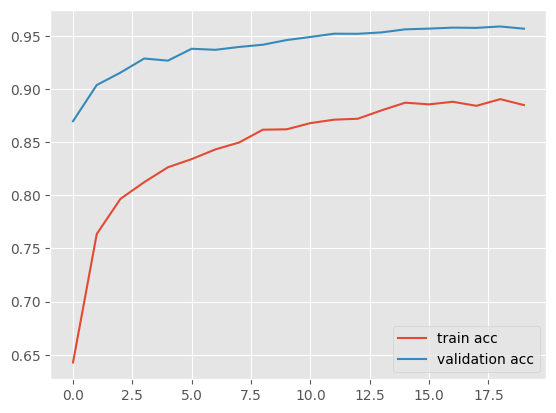

In [ ]:
plt.plot([accs_.cpu() for accs_ in accs], label="train acc")
plt.plot(val_accs, label="validation acc")
plt.legend()

## ZCA + Flip+ Crop + Rotation 10 + Mixup 0.2 + Randomsharpness


In [ ]:
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        x = images[0][0].reshape(1, -1)  # 画像（1枚）を1次元化
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)  # 平均値を格納するテンソル．xと同じ形状
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        # E: 固有値 V: 固有ベクトルを並べたもの
        E, V = torch.linalg.eigh(con_matrix)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())  # A(\Lambda + \epsilon I)^{1/2}A^T
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean  # x - \bar{x}
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x

zca = ZCAWhitening()
raw_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
zca.fit(raw_dataset)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.2),
    transforms.ToTensor(),
    zca
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    zca
])

raw_dataset =datasets.CIFAR10(root="./data", train=False, download=True, transform=None)
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
from torch.autograd import Variable
from tqdm import tqdm
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in tqdm(train_dataloader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        lam = np.random.beta(0.2, 0.2)
        perm = torch.randperm(imgs.size(0)).to(device)

        mixed_imgs = lam * imgs + (1 - lam) * imgs[perm]
        targets_a = labels
        targets_b = labels[perm]

        optimizer.zero_grad()
        output = model(mixed_imgs)
        loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        correct = lam * pred.eq(targets_a).float().mean() + (1 - lam) * pred.eq(targets_b).float().mean()
        running_acc += correct

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float()).item()

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)


    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))
    scheduler.step()

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

100%|██████████| 1563/1563 [01:42<00:00, 15.21it/s]


epoch: 0, loss: 1.1589089579789666, acc: 0.6269611120223999, val loss: 0.4152874187729991, val acc: 0.8733027156549521


100%|██████████| 1563/1563 [01:42<00:00, 15.32it/s]


epoch: 1, loss: 0.7766885795009038, acc: 0.7743028402328491, val loss: 0.2905387317839141, val acc: 0.9102436102236422


100%|██████████| 1563/1563 [01:41<00:00, 15.37it/s]


epoch: 2, loss: 0.693287503200697, acc: 0.8026427626609802, val loss: 0.29573304479876267, val acc: 0.9193290734824281


100%|██████████| 1563/1563 [01:41<00:00, 15.37it/s]


epoch: 3, loss: 0.6579999041696504, acc: 0.8153532147407532, val loss: 0.22189170883867307, val acc: 0.9332068690095847


100%|██████████| 1563/1563 [01:42<00:00, 15.22it/s]


epoch: 4, loss: 0.6057920378733543, acc: 0.8316004276275635, val loss: 0.3198930077469006, val acc: 0.9260183706070287


100%|██████████| 1563/1563 [01:43<00:00, 15.17it/s]


epoch: 5, loss: 0.5836242729105575, acc: 0.8392351269721985, val loss: 0.20394609964931734, val acc: 0.9400958466453674


100%|██████████| 1563/1563 [01:42<00:00, 15.23it/s]


epoch: 6, loss: 0.5657858016113593, acc: 0.8482348918914795, val loss: 0.1816015134747036, val acc: 0.9454872204472844


100%|██████████| 1563/1563 [01:42<00:00, 15.27it/s]


epoch: 7, loss: 0.5536543012647911, acc: 0.850948691368103, val loss: 0.17210745058668117, val acc: 0.948582268370607


100%|██████████| 1563/1563 [01:42<00:00, 15.26it/s]


epoch: 8, loss: 0.5598207991844328, acc: 0.8509584069252014, val loss: 0.1868932459015435, val acc: 0.9513777955271565


100%|██████████| 1563/1563 [01:42<00:00, 15.32it/s]


epoch: 9, loss: 0.4987018724557272, acc: 0.8684692978858948, val loss: 0.15965796892825787, val acc: 0.9518769968051118


100%|██████████| 1563/1563 [01:38<00:00, 15.84it/s]


epoch: 10, loss: 0.49597568390444063, acc: 0.8707368969917297, val loss: 0.16674049228382187, val acc: 0.9548722044728435


100%|██████████| 1563/1563 [01:39<00:00, 15.69it/s]


epoch: 11, loss: 0.4750907876524629, acc: 0.8773945569992065, val loss: 0.17112416682389978, val acc: 0.9550718849840255


100%|██████████| 1563/1563 [01:42<00:00, 15.29it/s]


epoch: 12, loss: 0.4734994753547518, acc: 0.8794358372688293, val loss: 0.14642280591324494, val acc: 0.955970447284345


100%|██████████| 1563/1563 [01:42<00:00, 15.24it/s]


epoch: 13, loss: 0.46369400146397655, acc: 0.8815271854400635, val loss: 0.13971375578794235, val acc: 0.959464856230032


100%|██████████| 1563/1563 [01:42<00:00, 15.26it/s]


epoch: 14, loss: 0.47150058039331183, acc: 0.8792040348052979, val loss: 0.17253081548137786, val acc: 0.9588658146964856


100%|██████████| 1563/1563 [01:42<00:00, 15.31it/s]


epoch: 15, loss: 0.4503920201451404, acc: 0.8831683397293091, val loss: 0.14955675318694342, val acc: 0.9629592651757188


100%|██████████| 1563/1563 [01:42<00:00, 15.26it/s]


epoch: 16, loss: 0.4490071679876613, acc: 0.8875487446784973, val loss: 0.1350233389225345, val acc: 0.9628594249201278


100%|██████████| 1563/1563 [01:42<00:00, 15.25it/s]


epoch: 17, loss: 0.4409073973166913, acc: 0.8899193406105042, val loss: 0.13524543090512198, val acc: 0.9625599041533547


100%|██████████| 1563/1563 [01:42<00:00, 15.22it/s]


epoch: 18, loss: 0.43168532015962535, acc: 0.8909745812416077, val loss: 0.14908752867731803, val acc: 0.9625599041533547


100%|██████████| 1563/1563 [01:42<00:00, 15.23it/s]


epoch: 19, loss: 0.42189974182282985, acc: 0.8941588997840881, val loss: 0.1350725945204306, val acc: 0.9648562300319489
Accuracy       : 0.9648
Precision (macro): 0.9649
Recall (macro)   : 0.9648
F1 Score (macro): 0.9648


Accuracy: 0.9648

Classification Report:
               precision    recall  f1-score   support

       plane     0.9739    0.9690    0.9714      1000
         car     0.9752    0.9840    0.9796      1000
        bird     0.9723    0.9480    0.9600      1000
         cat     0.9113    0.9250    0.9181      1000
        deer     0.9681    0.9700    0.9690      1000
         dog     0.9315    0.9390    0.9353      1000
        frog     0.9753    0.9890    0.9821      1000
       horse     0.9809    0.9750    0.9779      1000
        ship     0.9819    0.9780    0.9800      1000
       truck     0.9788    0.9710    0.9749      1000

    accuracy                         0.9648     10000
   macro avg     0.9649    0.9648    0.9648     10000
weighted avg     0.9649    0.9648    0.9648     10000



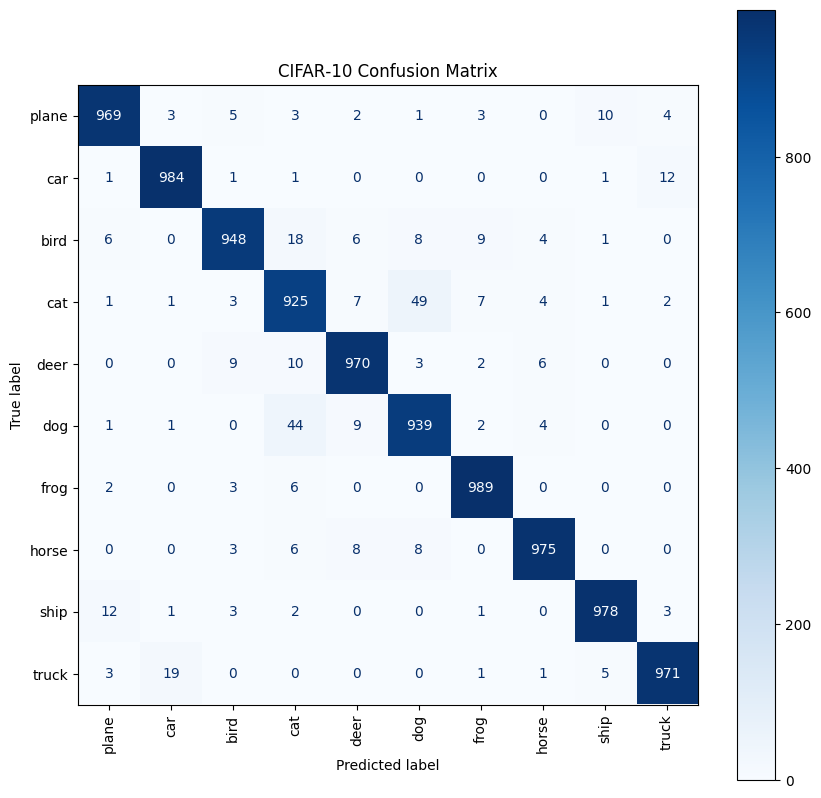

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.show()

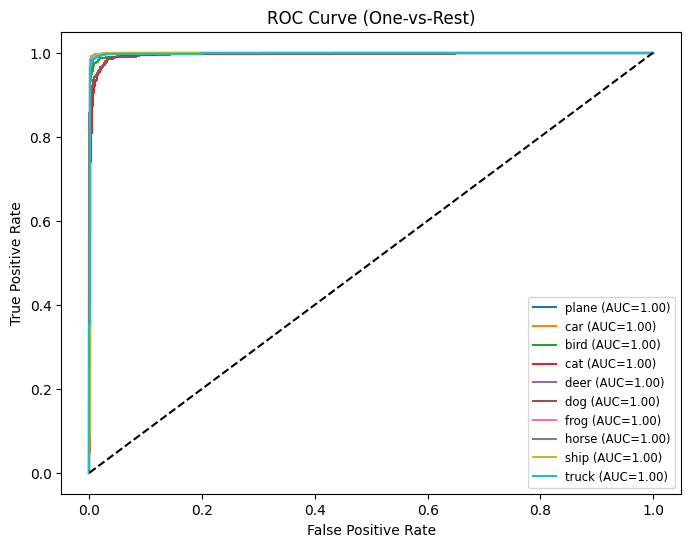

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.show()

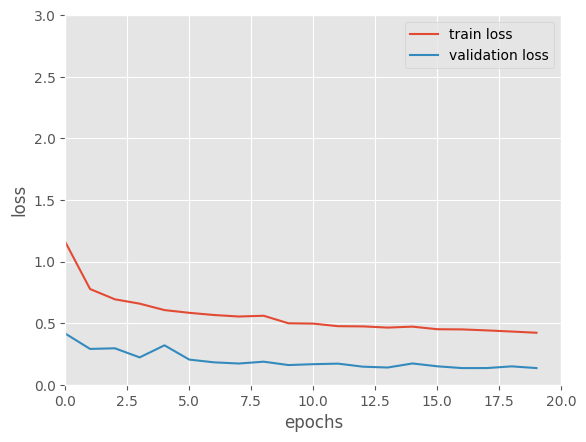

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0,20)
plt.ylim(0,3)
plt.legend()

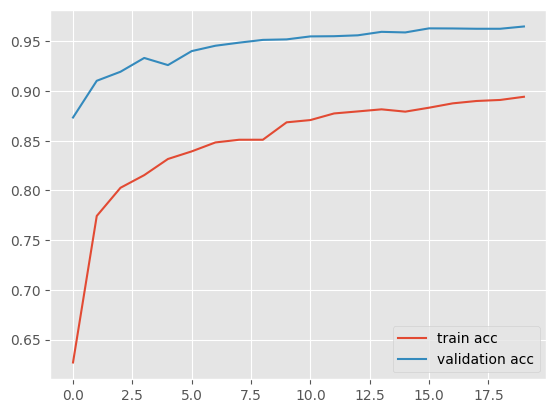

In [ ]:
plt.plot([accs_.cpu() for accs_ in accs], label="train acc")
plt.plot(val_accs, label="validation acc")
plt.legend()

#Resize

##Basic

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])


val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float()).item()

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)

        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float()).item()

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

epoch: 0, loss: 0.6154136321866696, acc: 0.7976047664747281, val loss: 0.33380035644236467, val acc: 0.8908746006389776
epoch: 1, loss: 0.27923011863204966, acc: 0.9055102367242482, val loss: 0.29441711354179506, val acc: 0.9017571884984026
epoch: 2, loss: 0.1977756297143125, acc: 0.9320817338451696, val loss: 0.3333353550194171, val acc: 0.8947683706070287
epoch: 3, loss: 0.14892920487743855, acc: 0.948516474728087, val loss: 0.26897631400523664, val acc: 0.9170327476038339
epoch: 4, loss: 0.11423083336431573, acc: 0.9603926743442098, val loss: 0.2931112323236018, val acc: 0.9116413738019169
epoch: 5, loss: 0.08854966288304668, acc: 0.9697096928982726, val loss: 0.3261370967877225, val acc: 0.9112420127795527
epoch: 6, loss: 0.07869555870093696, acc: 0.9720489443378119, val loss: 0.28569686507133724, val acc: 0.9161341853035144
epoch: 7, loss: 0.07602065172866022, acc: 0.9737284069097889, val loss: 0.2535948365675315, val acc: 0.9252196485623003
epoch: 8, loss: 0.05501809169452516, ac

Accuracy: 0.9208

Classification Report:
               precision    recall  f1-score   support

       plane     0.9134    0.9180    0.9157      1000
         car     0.9630    0.9630    0.9630      1000
        bird     0.9289    0.8620    0.8942      1000
         cat     0.8754    0.8150    0.8441      1000
        deer     0.8703    0.9730    0.9188      1000
         dog     0.9220    0.8390    0.8785      1000
        frog     0.9358    0.9620    0.9487      1000
       horse     0.9425    0.9500    0.9462      1000
        ship     0.9011    0.9750    0.9366      1000
       truck     0.9606    0.9510    0.9558      1000

    accuracy                         0.9208     10000
   macro avg     0.9213    0.9208    0.9202     10000
weighted avg     0.9213    0.9208    0.9202     10000



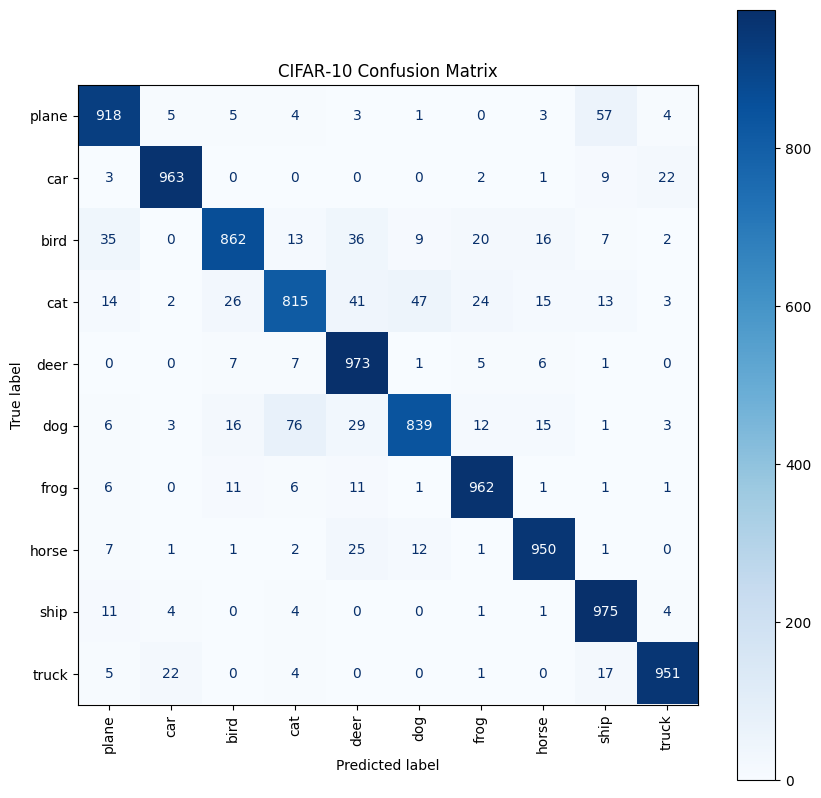

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.show()


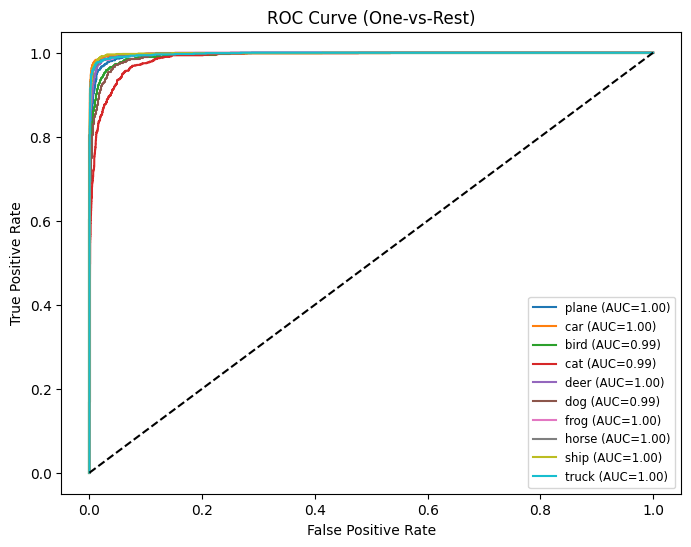

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.show()

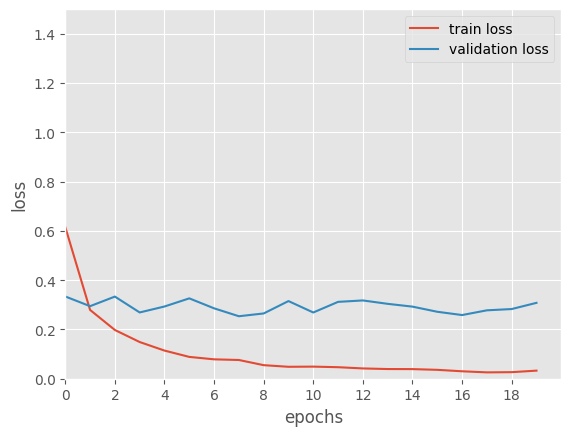

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0,20)
plt.ylim(0,1.5)
plt.xticks(range(0, 19, 2))
plt.legend()

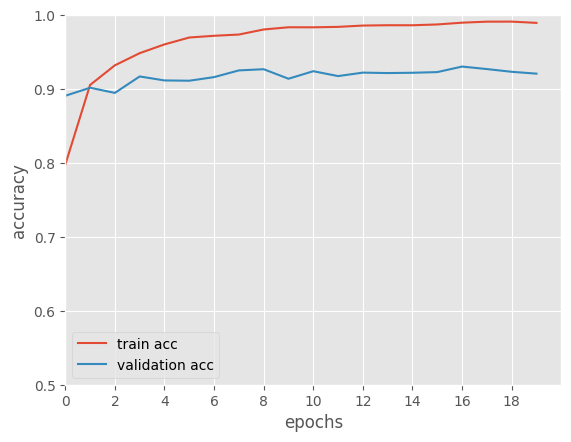

In [ ]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0,20)
plt.ylim(0.5,1)
plt.xticks(range(0, 19, 2))
plt.legend()